# The Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

**As an optional challenge** Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

## 1. Download the vehicle training dataset

In [1]:
from urllib.request import urlretrieve
from os.path import isdir
from tqdm import tqdm
import zipfile

vehicles_path = 'vehicles'
vehicles_file = 'vehicles.zip'
non_vehicles_path = 'non-vehicles'
non_vehicles_file = "non-vehicles.zip"

vehicles_link = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip'
non_vehicles_link ='https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip'


class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isdir(vehicles_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Vehicle Dataset') as pbar:
        urlretrieve(vehicles_link,vehicles_file, pbar.hook)
    
    with zipfile.ZipFile(vehicles_file,"r") as zip_ref:
        zip_ref.extractall(vehicles_path)

if not isdir(non_vehicles_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Non-Vehicle Dataset') as pbar:
        urlretrieve(non_vehicles_link,non_vehicles_file, pbar.hook)
        
    with zipfile.ZipFile(non_vehicles_file,"r") as zip_ref:
        zip_ref.extractall(non_vehicles_path)
        

## 2. Extract Histogram of Oriented Gradients (HOG) feature
Code is resued from lesson

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque 
from skimage.feature import hog
import cv2
import glob

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """ get image.hog() features
    Args:
        img : input image, must have shape (height,width) !!! no channel grayscale
        orient: number of orientation bins
        pixel_per_cell: size(in pixels) of a cell
        cell_per_block: nmber of cells in each block
        vis: return an image of HOG if True
        feature_vec:return the data as a feature vector if True
    Returns:
        features: HOG features
        hog_image: HOG Image
    
    """
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, block_norm='L2-Hys',
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, block_norm='L2-Hys',
                       visualise=vis, feature_vector=feature_vec)
        return features


In [4]:
# get images for cars and non-cars images files for training and validation
car_files = glob.glob("vehicles/vehicles/*/*.png")
non_car_files = glob.glob("non-vehicles/non-vehicles/*/*.png")
print("Total cars samples:{} Non cars samples :{}".format(len(car_files),len(non_car_files)))

Total cars samples:8792 Non cars samples :8968


### 2.1 show examples of cars and non-cars images

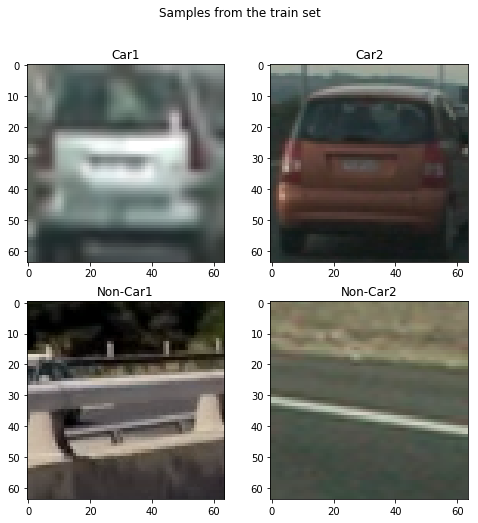

In [5]:
ind1,ind2 = np.random.randint(0,len(car_files),2)
car1= cv2.imread(car_files[ind1])
car2= cv2.imread(car_files[ind2])

ind1,ind2 = np.random.randint(0,len(non_car_files),2)
non_car1= cv2.imread(non_car_files[ind1])
non_car2= cv2.imread(non_car_files[ind2])

fig = plt.figure(figsize=(8,8))
plt.suptitle("Samples from the train set")

plt.subplot(2,2,1)
plt.title("Car1")
plt.imshow(cv2.cvtColor(car1,cv2.COLOR_BGR2RGB))

plt.subplot(2,2,2)
plt.title("Car2")
plt.imshow(cv2.cvtColor(car2,cv2.COLOR_BGR2RGB))

plt.subplot(2,2,3)
plt.title("Non-Car1")
plt.imshow(cv2.cvtColor(non_car1,cv2.COLOR_BGR2RGB))

plt.subplot(2,2,4)
plt.title("Non-Car2")
plt.imshow(cv2.cvtColor(non_car2,cv2.COLOR_BGR2RGB))

plt.show()

### 2.2 test HOG feature extracter

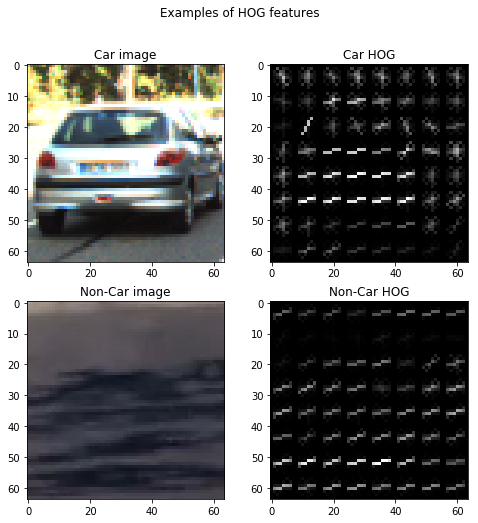

In [6]:
# pick an image randomly from train set
ind = np.random.randint(0,len(car_files))
car_img = cv2.imread(car_files[ind])

ind = np.random.randint(0,len(non_car_files))
non_car_img = cv2.imread(non_car_files[ind])

# apply HOG feature extraction
gray = cv2.cvtColor(car_img, cv2.COLOR_BGR2GRAY)
_, car_img_hog = get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=True)

gray = cv2.cvtColor(non_car_img, cv2.COLOR_BGR2GRAY)
vec, non_car_img_hog = get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)



fig = plt.figure(figsize=(8,8))
plt.suptitle("Examples of HOG features")

plt.subplot(2,2,1)
plt.title("Car image")
plt.imshow(cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB))

plt.subplot(2,2,2)
plt.title("Car HOG")
plt.imshow(car_img_hog,cmap='gray')

plt.subplot(2,2,3)
plt.title("Non-Car image")
plt.imshow(cv2.cvtColor(non_car_img,cv2.COLOR_BGR2RGB))

plt.subplot(2,2,4)
plt.title("Non-Car HOG")
plt.imshow(non_car_img_hog,cmap='gray')

plt.show()

## 3. binned color features, as well as histograms of color

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=32):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, (size,size)).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256),channel = "ALL"):
    # Compute the histogram of the color channels separately
    if channel == "ALL":
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    else: 
        hist_features = np.histogram(img[:,:,channel], bins=nbins, range=bins_range)
        
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### 3.1 test binned color features and histograms of colors

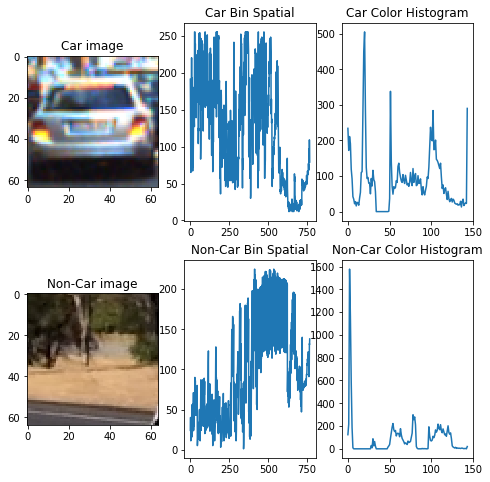

In [8]:
# pick an image randomly from train set
ind = np.random.randint(0,len(car_files))
car_img = cv2.imread(car_files[ind])

ind = np.random.randint(0,len(non_car_files))
non_car_img = cv2.imread(non_car_files[ind])

# apply bin and histogram of colors feature extraction
car_img_bin = bin_spatial(car_img, size = 16)
car_img_hls = cv2.cvtColor(car_img,cv2.COLOR_BGR2HLS)
car_img_his = color_hist(car_img_hls,nbins=48)

non_car_img_bin = bin_spatial(non_car_img, size = 16)
non_car_img_hls = cv2.cvtColor(non_car_img,cv2.COLOR_BGR2HLS)
non_car_img_his = color_hist(non_car_img_hls,nbins=48)


fig = plt.figure(figsize=(8,8))
plt.subplot(2,3,1)
plt.title("Car image")
plt.imshow(cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB))

plt.subplot(2,3,2)
plt.title("Car Bin Spatial")
plt.plot(car_img_bin)

plt.subplot(2,3,3)
plt.title("Car Color Histogram")
plt.plot(car_img_his)

plt.subplot(2,3,4)
plt.title("Non-Car image")
plt.imshow(cv2.cvtColor(non_car_img,cv2.COLOR_BGR2RGB))

plt.subplot(2,3,5)
plt.title("Non-Car Bin Spatial")
plt.plot(non_car_img_bin)

plt.subplot(2,3,6)
plt.title("Non-Car Color Histogram")
plt.plot(non_car_img_his)

plt.show()

## 4. train a SVM Linear Classifier

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist(), and get_hog_features()
def extract_features(img, cspace='BGR', spatial_size=32,hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2,hog_channel=0):
    """return a combination of bin spatial features, color histogram features and HOG features"""
    
    # apply color conversion if other than 'BGR'
    
    if cspace != 'BGR':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            
    else: feature_image =img  
    
    # Apply bin_spatial() to get spatial color features
 
    bin_features = bin_spatial(feature_image,size = spatial_size)
    
    # Apply color_hist() to get color histogram features
    
    col_his_features = color_hist(feature_image,nbins=hist_bins,bins_range=hist_range)
    
    # Append the new feature vector to the features list
    # if all channels are selected, then combine the HOGs from three channels
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
     
    # Return list of feature vectors
    return np.concatenate((bin_features,col_his_features,hog_features))
        


In [10]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def train_svm_classifier(colorspace, orient, pix_per_cell,cell_per_block,hog_channel,
                         spatial_bin_size, color_bin_size):
    
    """get a svm classifier and a feature scaler """
    
    # get images for cars and non-cars images files for training and validation
    car_files = glob.glob("vehicles/vehicles/*/*.png")
    non_car_files = glob.glob("non-vehicles/non-vehicles/*/*.png")
    print("Total cars samples:{} Non cars samples :{}".format(len(car_files),len(non_car_files)))
    
    t=time.time()
    car_features    = [extract_features(cv2.imread(file), cspace=colorspace, spatial_size=spatial_bin_size,
                            hist_bins=color_bin_size,hist_range=(0,255),orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
                       for file in car_files ]

    notcar_features = [extract_features(cv2.imread(file), cspace=colorspace, spatial_size=spatial_bin_size,
                            hist_bins=color_bin_size,hist_range=(0,255),orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
                       for file in non_car_files]
    
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features...')

    t=time.time()
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to normalize features')


    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc,X_scaler

## 5. Implement a sliding-window technique and use trained classifier to search for vehicles in images

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """ draw rectangles"""
    
    # Make a copy of the image
    imcopy = np.copy(img)
    # Draw a rectangle given bbox coordinates
    [cv2.rectangle(imcopy, box[0], box[1], color, thick) for box in bboxes]
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
   
    """ get a window/rectangle list for specified window size """
    
    # If x and/or y start/stop positions not defined, set to image size
    # Compute the span of the region to be searched  
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    
    #window width and height
    w = xy_window[1]
    h = xy_window[0]
    
    # Compute the number of pixels per step in x/y
   
    x_step = int(w * (1-xy_overlap[0]))
    y_step = int(h * (1-xy_overlap[1]))
    
    # Compute the number of windows in x/y
    x_window_pos = range(x_start_stop[0],x_start_stop[1]-w+1,x_step)
    y_window_pos = range(y_start_stop[0],y_start_stop[1]-h+1,y_step)
    
    # Loop through finding x and y window positions
    # Return the list of windows
    return [((x,y),(x+w-1,y+h-1)) for y in y_window_pos for x in x_window_pos]

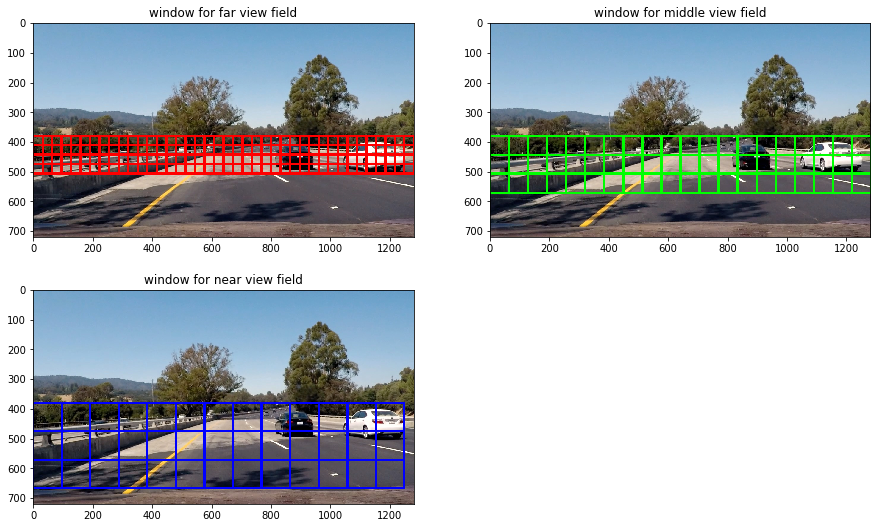

In [12]:
image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

windows_far = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 508], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)) 
windows_mid = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 600], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)) 
windows_near = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 720], 
                    xy_window=(192, 192), xy_overlap=(0.5, 0.5)) 

plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
window_img = draw_boxes(image, windows_far, color=(255, 0, 0), thick=6) 
plt.imshow(window_img)
plt.title("window for far view field")
plt.subplot(2,2,2)
window_img = draw_boxes(image, windows_mid, color=(0, 255, 0), thick=6) 
plt.imshow(window_img)
plt.title("window for middle view field")
plt.subplot(2,2,3)
window_img = draw_boxes(image, windows_near, color=(0, 0, 255), thick=6) 
plt.imshow(window_img)
plt.title("window for near view field")
plt.show()

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart,xstop,ystart, ystop, scale, orient, pix_per_cell, cell_per_block, cspace,hog_channel,
              spatial_size, hist_bins,svc, X_scaler,vis=False):
    """ automate the car search on one image 
    
    return:
        bb_list: box/rectangle list containing predicted car.
        draw_img: a image with predicted cars identified with bounding rectangle
        
    """
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    if cspace != 'BGR':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
        else: ctrans_tosearch = np.copy(img_tosearch)   
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    

    # Define blocks and steps as above
    
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == "ALL":
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        ch = ctrans_tosearch[:,:,hog_channel]
        hog1 = get_hog_features(ch, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),
                                  (xbox_left+xstart+win_draw,ytop_draw+win_draw+ystart)))
    
    if vis == True:
        draw_img = np.copy(img)
        draw_img = cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB)
        for (x1,y1),(x2,y2) in bbox_list:
            cv2.rectangle(draw_img,(x1, y1),(x2,y2),(0,0,255),6)
        return bbox_list,draw_img
    
    else:
        return bbox_list

## Parameters to adjust

In [14]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 #Can be 0, 1, 2, or "ALL"
spatial_bin_size = 16 #spatial bin size
color_bin_size = 32 #color bin size
scale =1

In [15]:
#create classifier
svc,scaler = train_svm_classifier(colorspace, orient, pix_per_cell,cell_per_block,hog_channel,
                         spatial_bin_size, color_bin_size)


Total cars samples:8792 Non cars samples :8968
82.66 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2628
0.71 Seconds to normalize features
5.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9837


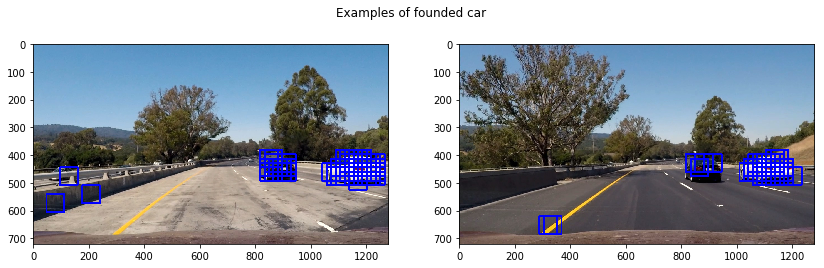

In [16]:
xstart = 0
xstop = 1280
ystart = 380
ystop = 700

img1 = cv2.imread('test_images/test1.jpg')
img6 = cv2.imread('test_images/test6.jpg')


_,out_img1 = find_cars(img1,xstart,xstop, ystart, ystop, scale, 
              orient, pix_per_cell, cell_per_block, colorspace,hog_channel,
             spatial_bin_size, color_bin_size,svc, scaler,vis=True)
_,out_img6 = find_cars(img6,xstart,xstop, ystart, ystop, scale, 
              orient, pix_per_cell, cell_per_block, colorspace,hog_channel,
             spatial_bin_size, color_bin_size,svc, scaler,vis=True)
    
plt.figure(figsize = (14,4))
plt.suptitle("Examples of founded car")
plt.subplot(1,2,1)
plt.imshow(out_img1)
plt.subplot(1,2,2)
plt.imshow(out_img6)
plt.show()

In [17]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_heat(heatmap, bbox_list,value=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] = value

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bb_list=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bb_list.append(bbox)
    # Return the image
    return img,bb_list


In [18]:
#Both parameters are used to remove false positive detections.
# frame count to average the heat
frames_to_average = 10
# frame count to validate, i.e. the video shall detect amount  of cars consectively to decide a new car is detected.
frames_to_validate = 10

# using multi-scale detection, the cars are only detected under certain scales
# by observing the samples, 2 out of 6 scales patches are detected in average
recognition_rate = 2

In [19]:
def validate_labels(labels,valid_labels,label_buffer):
    """function to validate the labels over the previous ones """

    # check only the counter of detected cars
    if valid_labels == None or labels[1] == valid_labels[1]:
        # new labels replace old one
        valid_labels = labels
        label_buffer.clear()
    else:
        # buffer the frame
        label_buffer.appendleft(labels)
        if len(label_buffer) >= label_buffer.maxlen:
            # we collected enough frames
            # check if new frame replace the valid_label
            replace = True
            # loop the buffer to check if they all have same count of cars
            for item in label_buffer:
                if item[1] !=labels[1]:
                    replace = False
            
            if replace == True:
                label_buffer.clear()
                valid_labels = labels
            else:
                # continue buffers, return old valid labels
                label_buffer.append(valid_labels)
                
    return valid_labels



def multi_scale_find_cars_pipeline(image,debug=False):
    #global variables to store the heat buffer across consective video frames
    #heat_buffer=deque(maxlen=frames_to_average)
    #label_buffer=deque(maxlen=frames_to_validate)
    #valid_label = None   
    
    #get self object
    selb = multi_scale_find_cars_pipeline
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    #for debug only to get the original rectangles.
    bboxes = []
    
    ystart = 380
    xstart = 0
    xstop = 1280
    ystops = [476,476,508,572,636,700]
    scales = [1,1.25,1.5,1.75,2,2.5]
    
    # detect cars from different scale of patches
    for scale,ystop in zip(scales,ystops):
        # the pipeline is applied in RGB image, convert to BGR for find_cars()
        bb_list,out_img = find_cars(cv2.cvtColor(image,cv2.COLOR_RGB2BGR),xstart,xstop, ystart, ystop, scale, 
              orient, pix_per_cell, cell_per_block, colorspace,hog_channel,
              spatial_bin_size, color_bin_size,svc, scaler,vis=True)
        
        #if car is detected, set the heat to 1
        heat_scale = np.zeros_like(image[:,:,0]).astype(np.float)
        heat_scale = apply_heat(heat_scale,bb_list,1)
        # sum over different scles
        heat += heat_scale
        
        #for debug only to get the original rectangles.
        bboxes += bb_list
    
    selb.heat_buffer.append(heat.copy())
    # average through the frames
    weight_heat = sum(selb.heat_buffer)
    # apply the threshold
    # this will remove partially the false positive
    weight_heat = apply_threshold(weight_heat, recognition_rate * len(selb.heat_buffer))
    
    # Find final boxes from heatmap using label function
    labels = label(weight_heat)
    
    
    #check if the label is valid accross the frames
    selb.valid_labels = validate_labels(labels,selb.valid_labels,selb.label_buffer)
     
    draw_img,_= draw_labeled_bboxes(image.copy(),selb.valid_labels)
   
    if debug:
        return selb.valid_labels,labels,heat,weight_heat,bboxes
    else:
        return draw_img

# wrapper to get pipe line including initializing buffers in pipeline.
def get_pipeline():
    pipeline = multi_scale_find_cars_pipeline
    pipeline.heat_buffer=deque(maxlen=frames_to_average)
    pipeline.label_buffer=deque(maxlen=frames_to_validate)
    pipeline.valid_labels = None 
    return pipeline

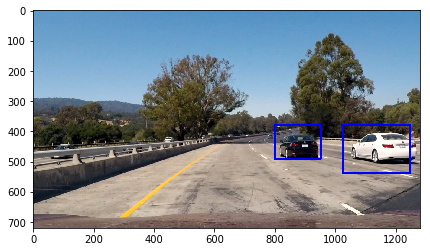

In [20]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

draw_img = get_pipeline()(image)


plt.figure(figsize = (14,4))
plt.imshow(draw_img)
plt.show()

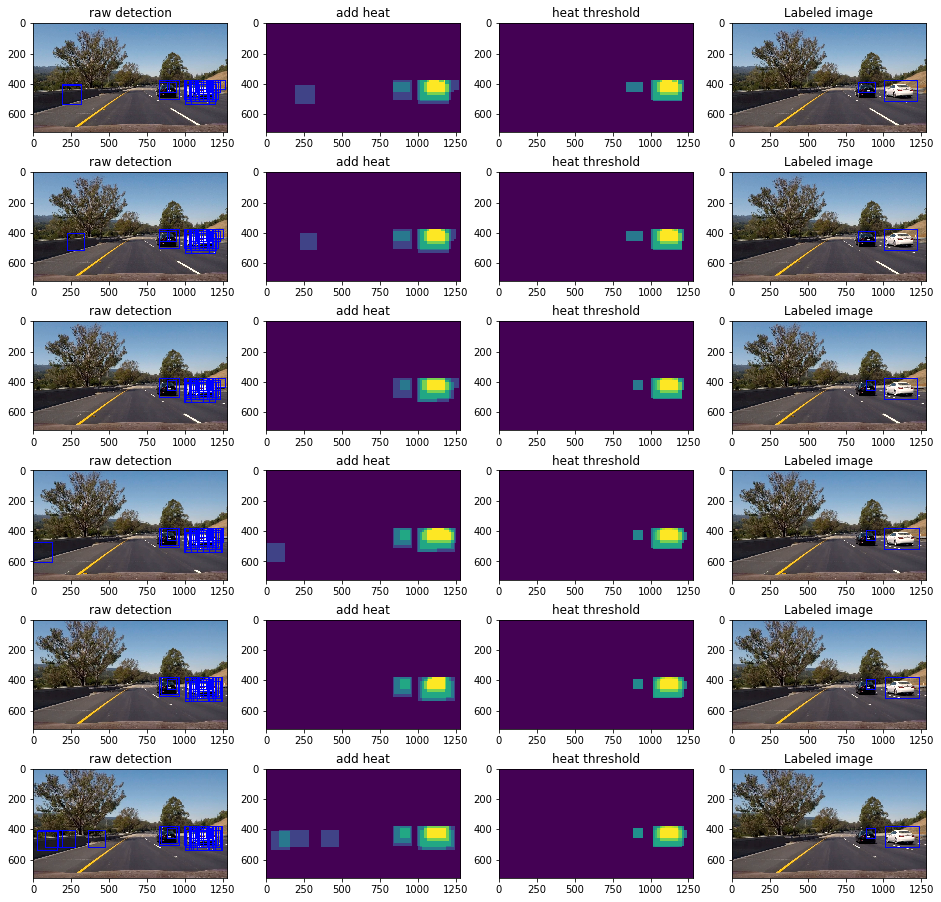

In [21]:
frames_files = glob.glob("frames/*.png")
pipeline = get_pipeline()

plt.figure(figsize=(16,16))

for i,file in enumerate(frames_files[0:6]):
    image = cv2.imread(file)
    image_rbg = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    valid_labels,labels,heat,weight_heat,bboxes = pipeline(image_rbg,debug=True)
    
    plt.subplot(6,4,i*4+1)
    draw_img = draw_boxes(image_rbg,bboxes)
    plt.title("raw detection")
    plt.imshow(draw_img)
    
    plt.subplot(6,4,i*4+2)
    plt.title("add heat")
    plt.imshow(heat)
    
    plt.subplot(6,4,i*4+3)
    plt.title("heat threshold")
    plt.imshow(weight_heat)
    
    plt.subplot(6,4,i*4+4)
    plt.title("Labeled image")
    draw_img, _ = draw_labeled_bboxes(image_rbg,valid_labels)
    plt.imshow(draw_img)
       
plt.show()

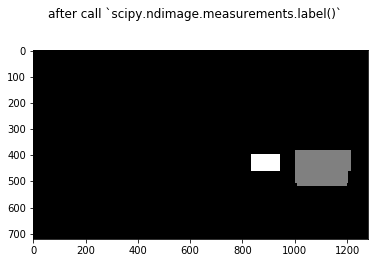

In [22]:
image = cv2.imread('frames/out1.png')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

valid_labels,labels,heat,weight_heat,bboxes = get_pipeline()(image,debug=True)

plt.figure()
plt.suptitle("after call `scipy.ndimage.measurements.label()`")
plt.imshow(valid_labels[0],cmap='gray')
plt.show()

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
pipeline = get_pipeline()
output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 30.8 s, sys: 144 ms, total: 30.9 s
Wall time: 21.4 s


In [24]:
# Import everything needed to edit/save/watch video clips
#from moviepy.editor import VideoFileClip
#pipeline = get_pipeline()
#output = 'project_video_output.mp4'
#clip1 = VideoFileClip("project_video.mp4")
#clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
#%time clip.write_videofile(output, audio=False)

In [25]:
import LaneDetection as ld

corners not found in file : camera_cal/calibration1.jpg
corners not found in file : camera_cal/calibration4.jpg
corners not found in file : camera_cal/calibration5.jpg


In [26]:
vd_pipeline = get_pipeline()

def combined_pipeline(img):
    step1_image = ld.pipeline(img)
    result = vd_pipeline(img,debug=True)
    
    draw_img,_ = draw_labeled_bboxes(step1_image,result[0])
    return draw_img
    

In [27]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(combined_pipeline) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [15:44<00:00,  1.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 23min 51s, sys: 4.34 s, total: 23min 56s
Wall time: 15min 45s
